In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import statistics
from scipy.optimize import curve_fit
from scipy import stats

data = pd.read_csv ("Allsupernovae.csv") #reading in supernovae data and creating data frame 'data'

cosmo = FlatLambdaCDM(H0=70, Om0=0.287) #H0 value from Betoule et al. 2014, omega_m best fit value from JLA sample, 
                                        #cosmological model assuming flat Universe

#Calculating distances 
data['d_L'] = cosmo.luminosity_distance(data.zcmb) #changing cmb redshift to distance in Mpc

#Distance modulus eq 
#mu = 5log(d_L/10pc) or bmag-absmag = mu = 5 log10(D_L) + 25 if D_L is in Mpc
data['mu'] = 5*(np.log10(data.d_L)) + 25


    
#step to correct Bet's distance modulus
data['MBstep'] = data.loc[data['LogMst'] >= 10,['deltaM']] #records deltaM in array if LogMst >=10
data['MBstep'].fillna(0, inplace=True) #otherwise records 0
correction = np.array(data.MBstep) #array of mass step corrections (i.e. either -0.07 or 0)

#Distance modulus eq
data['distance_modulus'] = data.mb - (data.MB1 - data.alpha*data.X1 + data.beta*data.c) 


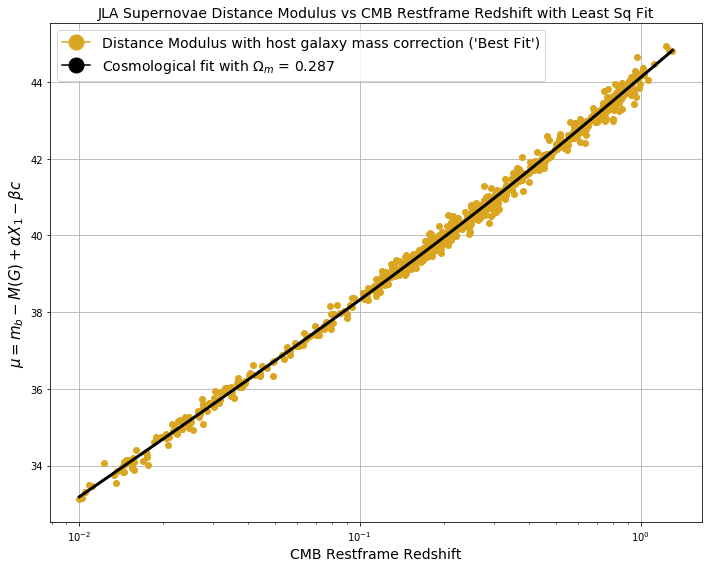

In [2]:
#Least sqs fit for data with step function
def func(x, absmag, alpha, beta):
        return x[0] - ((absmag+mass_corr) - alpha*x[1] + beta*x[2])  

#making array of data to put into function
b = np.array(data.mb)
c = np.array(data.X1)
d = np.array(data.c)
a = np.array([b,c,d])

#mass step function array (correction only)
data['MBstep'] = data.loc[data['LogMst'] >= 10,['mydeltaM']]
data['MBstep'].fillna(0, inplace=True)
mass_corr = np.array(data.MBstep)

#step function correction for sSFR
data['MBstep2'] = data.loc[data['logsSFR'] <= -10.5,['deltaM_sSFR']]
data['MBstep2'].fillna(0, inplace=True)
sSFR_corr = np.array(data.MBstep2)


#Making initial guess at absmag, alpha, beta values
init_guess = [9, 0.14, 3]
data['err'] = np.std((data.mb - ((data.MB1) 
                            - data.alpha*data.X1 + data.beta*data.c)) - data.mu)
    
#curve_fit
best_vals, cov = curve_fit(func, a, data.mu, p0=init_guess)

fig = plt.figure(figsize=(10,8)) 
#plt.plot(data.zcmb, data.distance_modulus, 'o', color='midnightblue')
plt.plot(data.zcmb, func(a, *best_vals), 'o', color='goldenrod')


#plotting luminosity distances for supernovae
plt.plot(np.sort(data.zcmb), np.sort(data.mu), linewidth=3, color='k')

#Making a legend
#blue_line = mlines.Line2D([], [], color='midnightblue', marker='o',markersize=15, 
             #label='Distance Modulus with host galaxy mass correction (Bet.)')
gold_line = mlines.Line2D([], [], color='goldenrod', marker='o',markersize=15, 
            label='Distance Modulus with host galaxy mass correction (\'Best Fit\')')
black_line = mlines.Line2D([], [], color='k', marker='o',markersize=15, label='Cosmological fit with $\Omega_m$ = 0.287')
plt.legend(handles=[gold_line, black_line], fontsize=14)

#Title and axes
plt.title('JLA Supernovae Distance Modulus vs CMB Restframe Redshift with Least Sq Fit', fontsize=14)
plt.xscale('log')
plt.xlabel('CMB Restframe Redshift', fontsize=14)
plt.ylabel(r'$\mu = m_{b} - M(G) + \alpha X_{1} - \beta c$', fontsize=15)
plt.grid(True)
plt.tight_layout()


plt.show()

#fig.savefig('Distance Modulus Curve Fit(JLA)(no Bet).pdf')
plt.close(fig)

In [16]:
print(best_vals)
print(np.sqrt(np.diag(cov)))

[-19.05092325   0.12653781   2.48138709]
[ 0.00612701  0.0059707   0.07017316]
